# Regularization and Evaluation of Neural Networks

In [2]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [5]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [6]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 0s 770us/step - loss: 0.5310 - accuracy: 0.7774
Epoch 2/50
180/180 [==============================] - 0s 826us/step - loss: 0.2765 - accuracy: 0.8926
Epoch 3/50
180/180 [==============================] - 0s 867us/step - loss: 0.2019 - accuracy: 0.9226
Epoch 4/50
180/180 [==============================] - 0s 861us/step - loss: 0.1691 - accuracy: 0.9388
Epoch 5/50
180/180 [==============================] - 0s 812us/step - loss: 0.1405 - accuracy: 0.9494
Epoch 6/50
180/180 [==============================] - 0s 855us/step - loss: 0.1251 - accuracy: 0.9533
Epoch 7/50
180/180 [==============================] - 0s 791us/step - loss: 0.1098 - accuracy: 0.9544
Epoch 8/50
180/180 [==============================] - 0s 830us/step - loss: 0.1023 - accuracy: 0.9583
Epoch 9/50
180/180 [==============================] - 0s 821us/step - loss: 0.0896 - accuracy: 0.9616
Epoch 10/50
180/180 [==============================] - 0s 872us/step - loss: 0.085

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [7]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

In [9]:
X_pure_train.shape

(1149, 64)

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [8]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 753us/step - loss: 0.7078 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7046 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 861us/step - loss: 0.7019 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6998 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 895us/step - loss: 0.6982 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 986us/step - loss: 0.6969 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 844us/step - loss: 0.6959 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 796us/step - loss: 0.6951 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6945 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 816us/step - loss: 0.6941 - accuracy: 0.4961


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [10]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fa732271a00>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7078335881233215,
   0.7045684456825256,
   0.701851487159729,
   0.6997787952423096,
   0.698196291923523,
   0.6968908905982971,
   0.695915699005127,
   0.695063591003418,
   0.694491982460022,
   0.6940781474113464],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

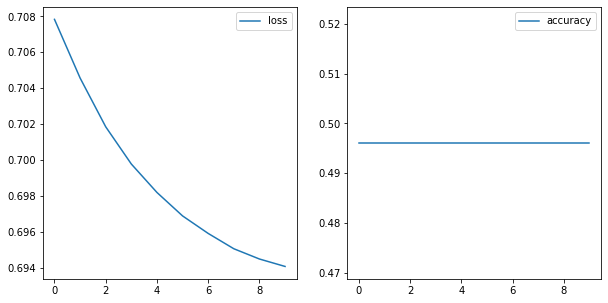

In [11]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [12]:
X_pure_train.shape[0]

1149

In [18]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=50, verbose=1)

Epoch 1/100
23/23 [==============================] - 0s 901us/step - loss: 0.6966 - accuracy: 0.4473
Epoch 2/100
23/23 [==============================] - 0s 897us/step - loss: 0.6897 - accuracy: 0.5265
Epoch 3/100
23/23 [==============================] - 0s 834us/step - loss: 0.6831 - accuracy: 0.6101
Epoch 4/100
23/23 [==============================] - 0s 899us/step - loss: 0.6773 - accuracy: 0.6789
Epoch 5/100
23/23 [==============================] - 0s 881us/step - loss: 0.6728 - accuracy: 0.7006
Epoch 6/100
23/23 [==============================] - 0s 896us/step - loss: 0.6688 - accuracy: 0.7206
Epoch 7/100
23/23 [==============================] - 0s 953us/step - loss: 0.6648 - accuracy: 0.7241
Epoch 8/100
23/23 [==============================] - 0s 879us/step - loss: 0.6606 - accuracy: 0.7398
Epoch 9/100
23/23 [==============================] - 0s 757us/step - loss: 0.6562 - accuracy: 0.7467
Epoch 10/100
23/23 [==============================] - 0s 957us/step - loss: 0.6513 - accura

23/23 [==============================] - 0s 882us/step - loss: 0.2052 - accuracy: 0.9147
Epoch 82/100
23/23 [==============================] - 0s 1ms/step - loss: 0.2037 - accuracy: 0.9147
Epoch 83/100
23/23 [==============================] - 0s 955us/step - loss: 0.2028 - accuracy: 0.9156
Epoch 84/100
23/23 [==============================] - 0s 873us/step - loss: 0.2018 - accuracy: 0.9164
Epoch 85/100
23/23 [==============================] - 0s 970us/step - loss: 0.2005 - accuracy: 0.9138
Epoch 86/100
23/23 [==============================] - 0s 747us/step - loss: 0.1994 - accuracy: 0.9156
Epoch 87/100
23/23 [==============================] - 0s 914us/step - loss: 0.1992 - accuracy: 0.9138
Epoch 88/100
23/23 [==============================] - 0s 888us/step - loss: 0.1980 - accuracy: 0.9164
Epoch 89/100
23/23 [==============================] - 0s 915us/step - loss: 0.1968 - accuracy: 0.9173
Epoch 90/100
23/23 [==============================] - 0s 785us/step - loss: 0.1951 - accuracy: 0.

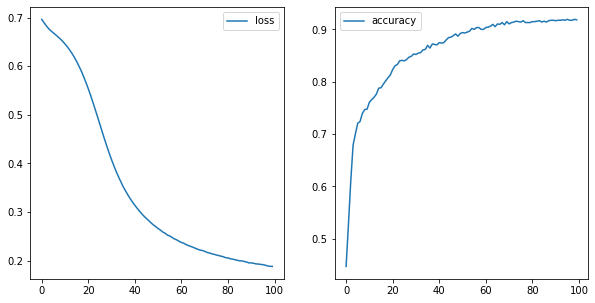

In [19]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 757us/step - loss: 1.1115 - accuracy: 0.4891
Epoch 2/30
115/115 [==============================] - 0s 724us/step - loss: 0.9850 - accuracy: 0.4961
Epoch 3/30
115/115 [==============================] - 0s 748us/step - loss: 0.9589 - accuracy: 0.5100
Epoch 4/30
115/115 [==============================] - 0s 697us/step - loss: 1.0108 - accuracy: 0.4856
Epoch 5/30
115/115 [==============================] - 0s 762us/step - loss: 0.9499 - accuracy: 0.5083
Epoch 6/30
115/115 [==============================] - 0s 702us/step - loss: 0.9446 - accuracy: 0.5152
Epoch 7/30
115/115 [==============================] - 0s 796us/step - loss: 1.0291 - accuracy: 0.4822
Epoch 8/30
115/115 [==============================] - 0s 827us/step - loss: 1.0668 - accuracy: 0.4883
Epoch 9/30
115/115 [==============================] - 0s 775us/step - loss: 0.9807 - accuracy: 0.4970
Epoch 10/30
115/115 [==============================] - 0s 776us/step - loss: 1.003

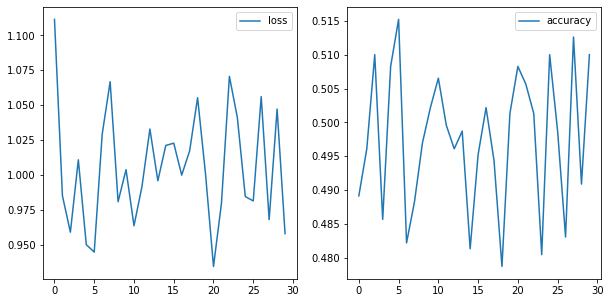

In [20]:
model = Sequential()

sgd = SGD(learning_rate=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.7476 - val_loss: 0.4718 - val_accuracy: 0.7847
Epoch 2/30
115/115 [==============================] - 0s 1ms/step - loss: 0.3774 - accuracy: 0.8555 - val_loss: 0.3276 - val_accuracy: 0.8611
Epoch 3/30
115/115 [==============================] - 0s 1ms/step - loss: 0.2836 - accuracy: 0.8877 - val_loss: 0.2669 - val_accuracy: 0.9062
Epoch 4/30
115/115 [==============================] - 0s 1ms/step - loss: 0.2278 - accuracy: 0.9043 - val_loss: 0.2155 - val_accuracy: 0.9201
Epoch 5/30
115/115 [==============================] - 0s 1ms/step - loss: 0.1937 - accuracy: 0.9234 - val_loss: 0.1807 - val_accuracy: 0.9340
Epoch 6/30
115/115 [==============================] - 0s 1ms/step - loss: 0.1702 - accuracy: 0.9278 - val_loss: 0.1767 - val_accuracy: 0.9271
Epoch 7/30
115/115 [==============================] - 0s 1ms/step - loss: 0.1505 - accuracy: 0.9356 - val_loss: 0.1482 - val_accuracy: 0.9479
Epoch 

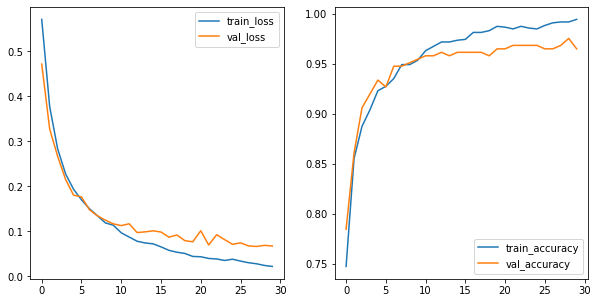

In [21]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train, epochs=30, batch_size=10, verbose=1, validation_data=(X_val, y_val))


train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [22]:
results.history['val_accuracy'][-1]

0.9652777910232544

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [23]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa71c591760> does not.

In [24]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [25]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=2)

In [26]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [27]:
# Can now cross_val
cross_val_score(keras_model, X_pure_train, y_pure_train, cv=3)

Epoch 1/50
24/24 - 0s - loss: 0.7193 - accuracy: 0.5052
Epoch 2/50
24/24 - 0s - loss: 0.6905 - accuracy: 0.5287
Epoch 3/50
24/24 - 0s - loss: 0.6636 - accuracy: 0.6828
Epoch 4/50
24/24 - 0s - loss: 0.6154 - accuracy: 0.7480
Epoch 5/50
24/24 - 0s - loss: 0.5378 - accuracy: 0.7990
Epoch 6/50
24/24 - 0s - loss: 0.4483 - accuracy: 0.8303
Epoch 7/50
24/24 - 0s - loss: 0.3764 - accuracy: 0.8616
Epoch 8/50
24/24 - 0s - loss: 0.3209 - accuracy: 0.8825
Epoch 9/50
24/24 - 0s - loss: 0.2841 - accuracy: 0.8982
Epoch 10/50
24/24 - 0s - loss: 0.2572 - accuracy: 0.9073
Epoch 11/50
24/24 - 0s - loss: 0.2356 - accuracy: 0.9191
Epoch 12/50
24/24 - 0s - loss: 0.2185 - accuracy: 0.9191
Epoch 13/50
24/24 - 0s - loss: 0.2060 - accuracy: 0.9256
Epoch 14/50
24/24 - 0s - loss: 0.1997 - accuracy: 0.9191
Epoch 15/50
24/24 - 0s - loss: 0.1878 - accuracy: 0.9282
Epoch 16/50
24/24 - 0s - loss: 0.1790 - accuracy: 0.9308
Epoch 17/50
24/24 - 0s - loss: 0.1702 - accuracy: 0.9321
Epoch 18/50
24/24 - 0s - loss: 0.1630 - 

Epoch 44/50
24/24 - 0s - loss: 0.0588 - accuracy: 0.9817
Epoch 45/50
24/24 - 0s - loss: 0.0533 - accuracy: 0.9843
Epoch 46/50
24/24 - 0s - loss: 0.0539 - accuracy: 0.9830
Epoch 47/50
24/24 - 0s - loss: 0.0506 - accuracy: 0.9843
Epoch 48/50
24/24 - 0s - loss: 0.0505 - accuracy: 0.9843
Epoch 49/50
24/24 - 0s - loss: 0.0469 - accuracy: 0.9843
Epoch 50/50
24/24 - 0s - loss: 0.0465 - accuracy: 0.9869
12/12 - 0s - loss: 0.1108 - accuracy: 0.9530


array([0.95300263, 0.9634465 , 0.95300263])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

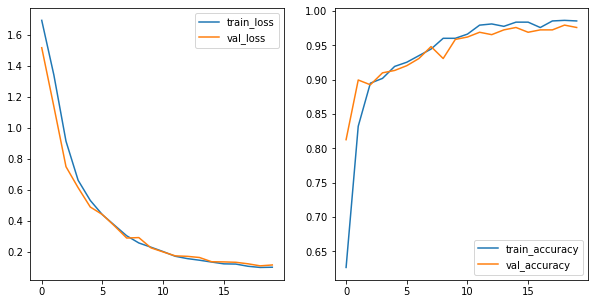

In [28]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu', kernel_regularizer=l2(0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

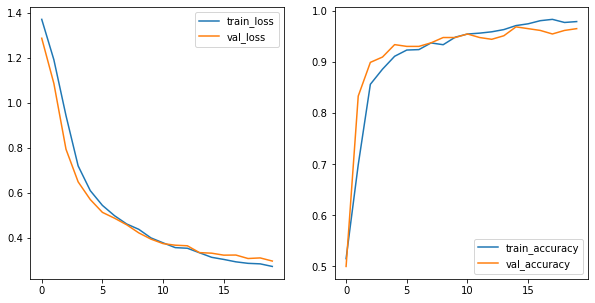

In [30]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

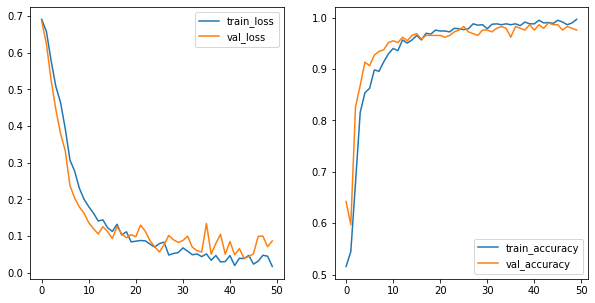

In [32]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [33]:
results.history['val_accuracy'][-1]

0.9756944179534912

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00013: early stopping


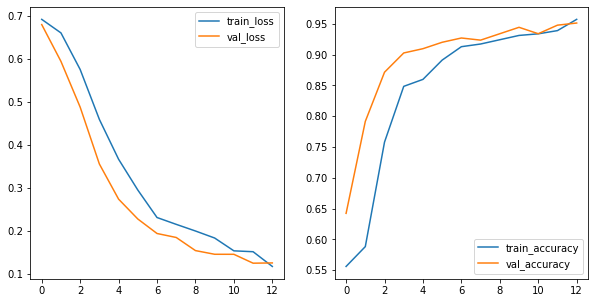

In [34]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00045: early stopping


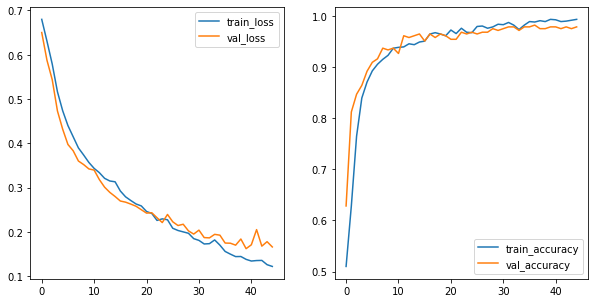

In [35]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [36]:
results.history['val_accuracy'][-1]

0.9791666865348816

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [37]:
digits = load_digits()
X = digits.data
y = digits.target

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [39]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [40]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
# Final layer will look different need a node for each class
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 2ms/step - loss: 2.2472 - accuracy: 0.1688 - val_loss: 2.1507 - val_accuracy: 0.2118
Epoch 2/50
115/115 [==============================] - 0s 1ms/step - loss: 2.0068 - accuracy: 0.2811 - val_loss: 1.7813 - val_accuracy: 0.3507
Epoch 3/50
115/115 [==============================] - 0s 992us/step - loss: 1.6265 - accuracy: 0.3681 - val_loss: 1.4356 - val_accuracy: 0.5243
Epoch 4/50
115/115 [==============================] - 0s 1ms/step - loss: 1.3257 - accuracy: 0.6162 - val_loss: 1.1927 - val_accuracy: 0.6736
Epoch 5/50
115/115 [==============================] - 0s 1ms/step - loss: 1.0937 - accuracy: 0.7076 - val_loss: 1.0091 - val_accuracy: 0.7604
Epoch 6/50
115/115 [==============================] - 0s 1ms/step - loss: 0.9081 - accuracy: 0.7850 - val_loss: 0.8444 - val_accuracy: 0.7917
Epoch 7/50
115/115 [==============================] - 0s 981us/step - loss: 0.7567 - accuracy: 0.8129 - val_loss: 0.7114 - val_accuracy: 0.8299
Ep

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [43]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

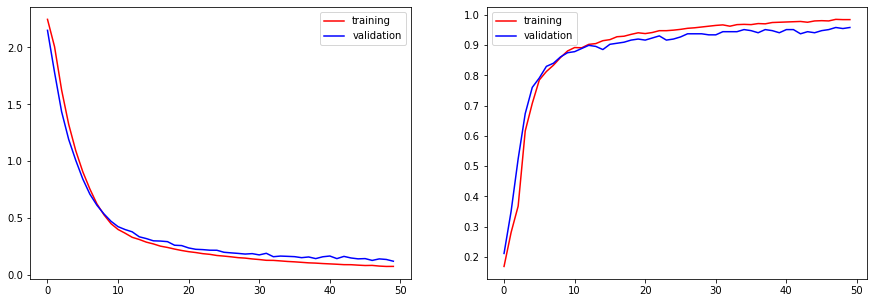

In [44]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [45]:
model.predict(X_test)

array([[2.1671187e-03, 7.8918587e-05, 2.2082787e-08, ..., 1.4864663e-13,
        8.2863797e-04, 2.8034449e-07],
       [3.3457934e-06, 2.0659212e-05, 4.9101662e-10, ..., 5.5641630e-07,
        7.4608334e-07, 9.2504686e-01],
       [1.2018569e-13, 2.7366108e-05, 6.0620896e-06, ..., 2.6326522e-10,
        1.3782987e-07, 2.4259403e-04],
       ...,
       [2.0423466e-04, 2.7235523e-03, 1.1912556e-05, ..., 2.9064526e-04,
        9.9383610e-01, 1.2619251e-03],
       [4.5967590e-07, 2.1132244e-02, 5.2535310e-03, ..., 4.1750892e-10,
        1.2800472e-02, 3.3403732e-02],
       [4.5914867e-06, 6.0258422e-08, 7.6444610e-07, ..., 4.4291948e-10,
        1.7735324e-07, 9.9076293e-03]], dtype=float32)

In [46]:
model.predict(X_test)[0]

array([2.1671187e-03, 7.8918587e-05, 2.2082787e-08, 2.3373987e-07,
       5.7656420e-05, 6.7966648e-05, 9.9679911e-01, 1.4864663e-13,
       8.2863797e-04, 2.8034449e-07], dtype=float32)

In [47]:
len(model.predict(X_test)[0])

10

In [48]:
model.predict(X_test)[0].sum()

1.0

In [53]:
y_hat_test = np.argmax(model.predict(X_test), axis=1)

In [54]:
y_hat_test

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 3, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 3, 5, 6, 0, 3, 0, 0, 1, 5, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 4, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 8, 7, 9, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 5, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 9, 5, 6, 6, 0,
       6, 4, 3, 9, 3, 9, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 1, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 9, 8, 5,
       5, 1, 0, 8, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 3, 7,
       7, 0, 1, 0, 4, 5, 8, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 4, 5, 3, 3, 8, 0, 5, 8, 3, 4, 0, 2,

In [55]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[31,  0,  0,  0,  1,  1,  0,  0,  0,  0],
       [ 0, 26,  0,  0,  0,  0,  0,  0,  1,  1],
       [ 0,  0, 28,  1,  0,  0,  0,  0,  4,  0],
       [ 0,  0,  0, 33,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 47,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  2,  0,  0,  1,  0,  0,  0, 25,  2],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0, 37]])

In [56]:
from sklearn.metrics import recall_score
recall_score(y_test_restore, y_hat_test, average='macro')

0.9387388591800357

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

